# Home Loan Approval Prediction Model
This dataset contains information about home loan applications, including applicant demographics, financial details, and loan characteristics. The goal is to build a predictive model to determine whether a loan application will be approved ("Y") or not ("N").

The dataset includes features such as:
- Gender, Marital Status, Dependents
- Education level, Self-Employment status
- Applicant and Coapplicant Income
- Loan Amount, Loan Term, Credit History
- Property Area

## Import Libraries
In this section, we need to import libraries that will be used in this project beforehand.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                            precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Load Datasets
After imported all the libraries that we need, now we're gonna load the datasets into this notebook using pandas.

In [2]:
# Load datasets
train = pd.read_csv(r'data\loan-train.csv')
test = pd.read_csv(r'data\loan-test.csv')

# Display first few rows of the train dataset
print("Train dimension:", train.shape[0], "rows and", train.shape[1], "columns")
print("Test dimension:", test.shape[0], "rows and", test.shape[1], "columns")
display(train.head())
print(train.info())

Train dimension: 614 rows and 13 columns
Test dimension: 367 rows and 12 columns


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


Preview of the first 5 rows shows a mix of categorical (Gender, Married, etc.) and numerical features (ApplicantIncome, LoanAmount).

In [3]:
# Unique values in train dataset
print("\nUnique values in each column of train dataset:\n")
print(train.nunique())

# Comprehensive summary table
pd.set_option('display.max_colwidth', 100)
print("\nSummary of train dataset:")
cardinality = train.nunique()[train.nunique() < 20].index
summary_data = []

for col in cardinality:
    unique_values = np.sort(train[col].dropna().unique())
    summary_data.append({
        'Column': col,
        'Unique Value & Value Counts': list(unique_values),
        'Total Unique Values': train[col].nunique()
    })
summary_df = pd.DataFrame(summary_data)
display(summary_df)


Unique values in each column of train dataset:

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

Summary of train dataset:


,Column,Unique Value & Value Counts,Total Unique Values
0,Gender,"[Female, Male]",2
1,Married,"[No, Yes]",2
2,Dependents,"[0, 1, 2, 3+]",4
3,Education,"[Graduate, Not Graduate]",2
4,Self_Employed,"[No, Yes]",2
5,Loan_Amount_Term,"[12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]",10
6,Credit_History,"[0.0, 1.0]",2
7,Property_Area,"[Rural, Semiurban, Urban]",3
8,Loan_Status,"[N, Y]",2


In [4]:
# Missing values check
print("Missing values in training set:\n")
print(train.isnull().sum())

Missing values in training set:

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [5]:
# Check for duplicates
print("\nNumber of duplicate rows in training set:", train.duplicated().sum())
print("Number of duplicate rows in test set:", test.duplicated().sum())


Number of duplicate rows in training set: 0
Number of duplicate rows in test set: 0


No duplicate rows were found in the dataset.

In [6]:
# Descriptive statistics
print("\nDescriptive statistics of numerical features:")
display(train.describe().T.round(2))


Descriptive statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.46,6109.04,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.25,2926.25,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.41,85.59,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.00,65.12,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.84,0.36,0.0,1.0,1.0,1.00,1.0


Summary statistics show potential skewness in `ApplicantIncome` and `CoapplicantIncome` (mean > median). `Credit_History` is binary (0/1).

## Exploratory Data Analysis

### Imbalance in target variable

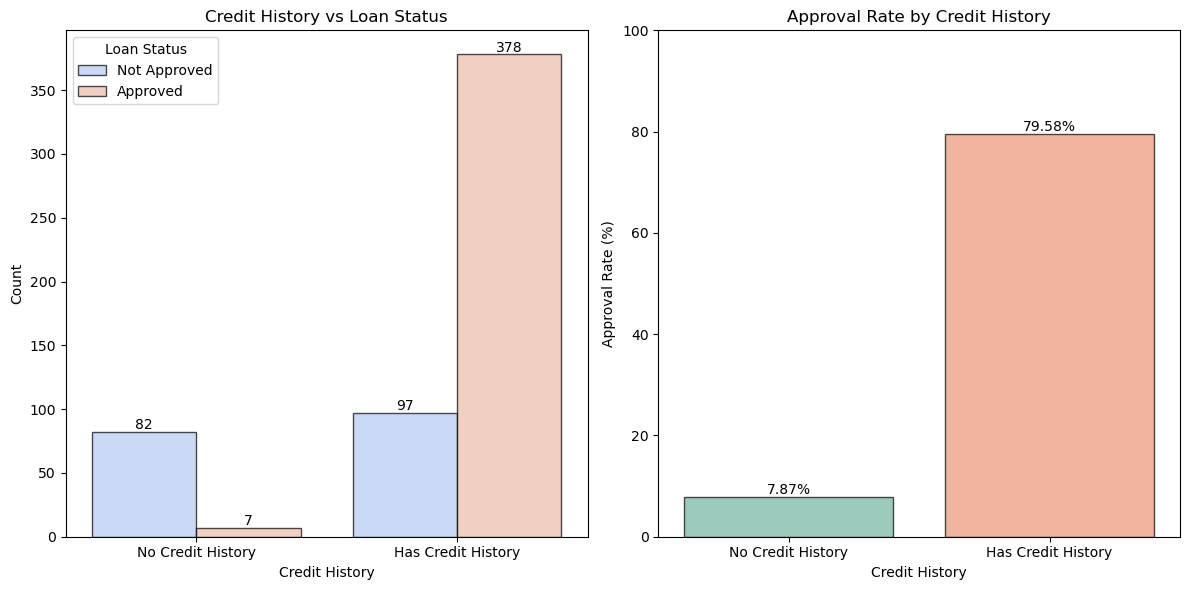


Target variable distribution in train set:


,Count,Proportion (%)
Loan_Status,,
Y,422,68.73
N,192,31.27


The target variable 'Loan_Status' is imbalanced with a high proportion of 'Y' (Approved) cases.

Approval rate by Credit History:



,Total Applications,Approved Applications,Approval Rate (%)
Credit_History,,,
0.0,89,7,7.87
1.0,475,378,79.58


In [7]:
# Create a subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of the target variable

sns.countplot(x='Credit_History', hue='Loan_Status', data=train, palette='coolwarm', edgecolor='black', alpha=0.7, ax=ax[0])
ax[0].set_title('Credit History vs Loan Status')
ax[0].set_xticks(ticks=[0,1], labels=['No Credit History', 'Has Credit History'])
ax[0].set_xlabel('Credit History')
ax[0].set_ylabel('Count')
ax[0].legend(title='Loan Status', labels=['Not Approved', 'Approved'])
for p in ax[0].patches:
    height = p.get_height()
    if height > 0:
        ax[0].annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')
    
# Approval rate by Credit History
approval_by_credit = train.groupby('Credit_History')['Loan_Status'].value_counts(normalize=True).unstack()*100
approval_by_credit = approval_by_credit.reset_index()
sns.barplot(x='Credit_History', y='Y', data=approval_by_credit, palette='Set2', edgecolor='black', alpha=0.7, ax=ax[1])
ax[1].set_title('Approval Rate by Credit History')
ax[1].set_xlabel('Credit History')
ax[1].set_ylabel('Approval Rate (%)')
ax[1].set_ylim(0, 100)
ax[1].set_xticks(ticks=[0,1], labels=['No Credit History', 'Has Credit History'])
for p in ax[1].patches:
    height = p.get_height()
    if height > 0:
        ax[1].annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
plt.show()

# Detailed distribution of target variable
print("\nTarget variable distribution in train set:")
dist_train = [train['Loan_Status'].value_counts().astype(int), (train['Loan_Status'].value_counts(normalize=True)*100).round(2)]
dist_train = pd.DataFrame(dist_train, index=['Count', 'Proportion (%)']).T
dist_train['Count'] = dist_train['Count'].astype(int)
display(dist_train)

# Check if the target variable is imbalanced
if 'Proportion (%)' in dist_train['Proportion (%)'] or dist_train['Proportion (%)']['Y'] > 0.6:
    print("The target variable 'Loan_Status' is imbalanced with a high proportion of 'Y' (Approved) cases.")
else:
    print("The target variable 'Loan_Status' is relatively balanced.")

print("\nApproval rate by Credit History:\n")

# Create a more informative display
approval_summary = train.groupby('Credit_History').agg({
    'Loan_Status': ['count', lambda x: (x == 'Y').sum(), lambda x: (x == 'Y').mean() * 100]
}).round(2)
approval_summary.columns = ['Total Applications', 'Approved Applications', 'Approval Rate (%)']
display(approval_summary)

The dataset is imbalanced with more approved loans. Credit History is a strong indicator: applicants with a history of 1.0 have a much higher approval rate.

### Categorical Distributions

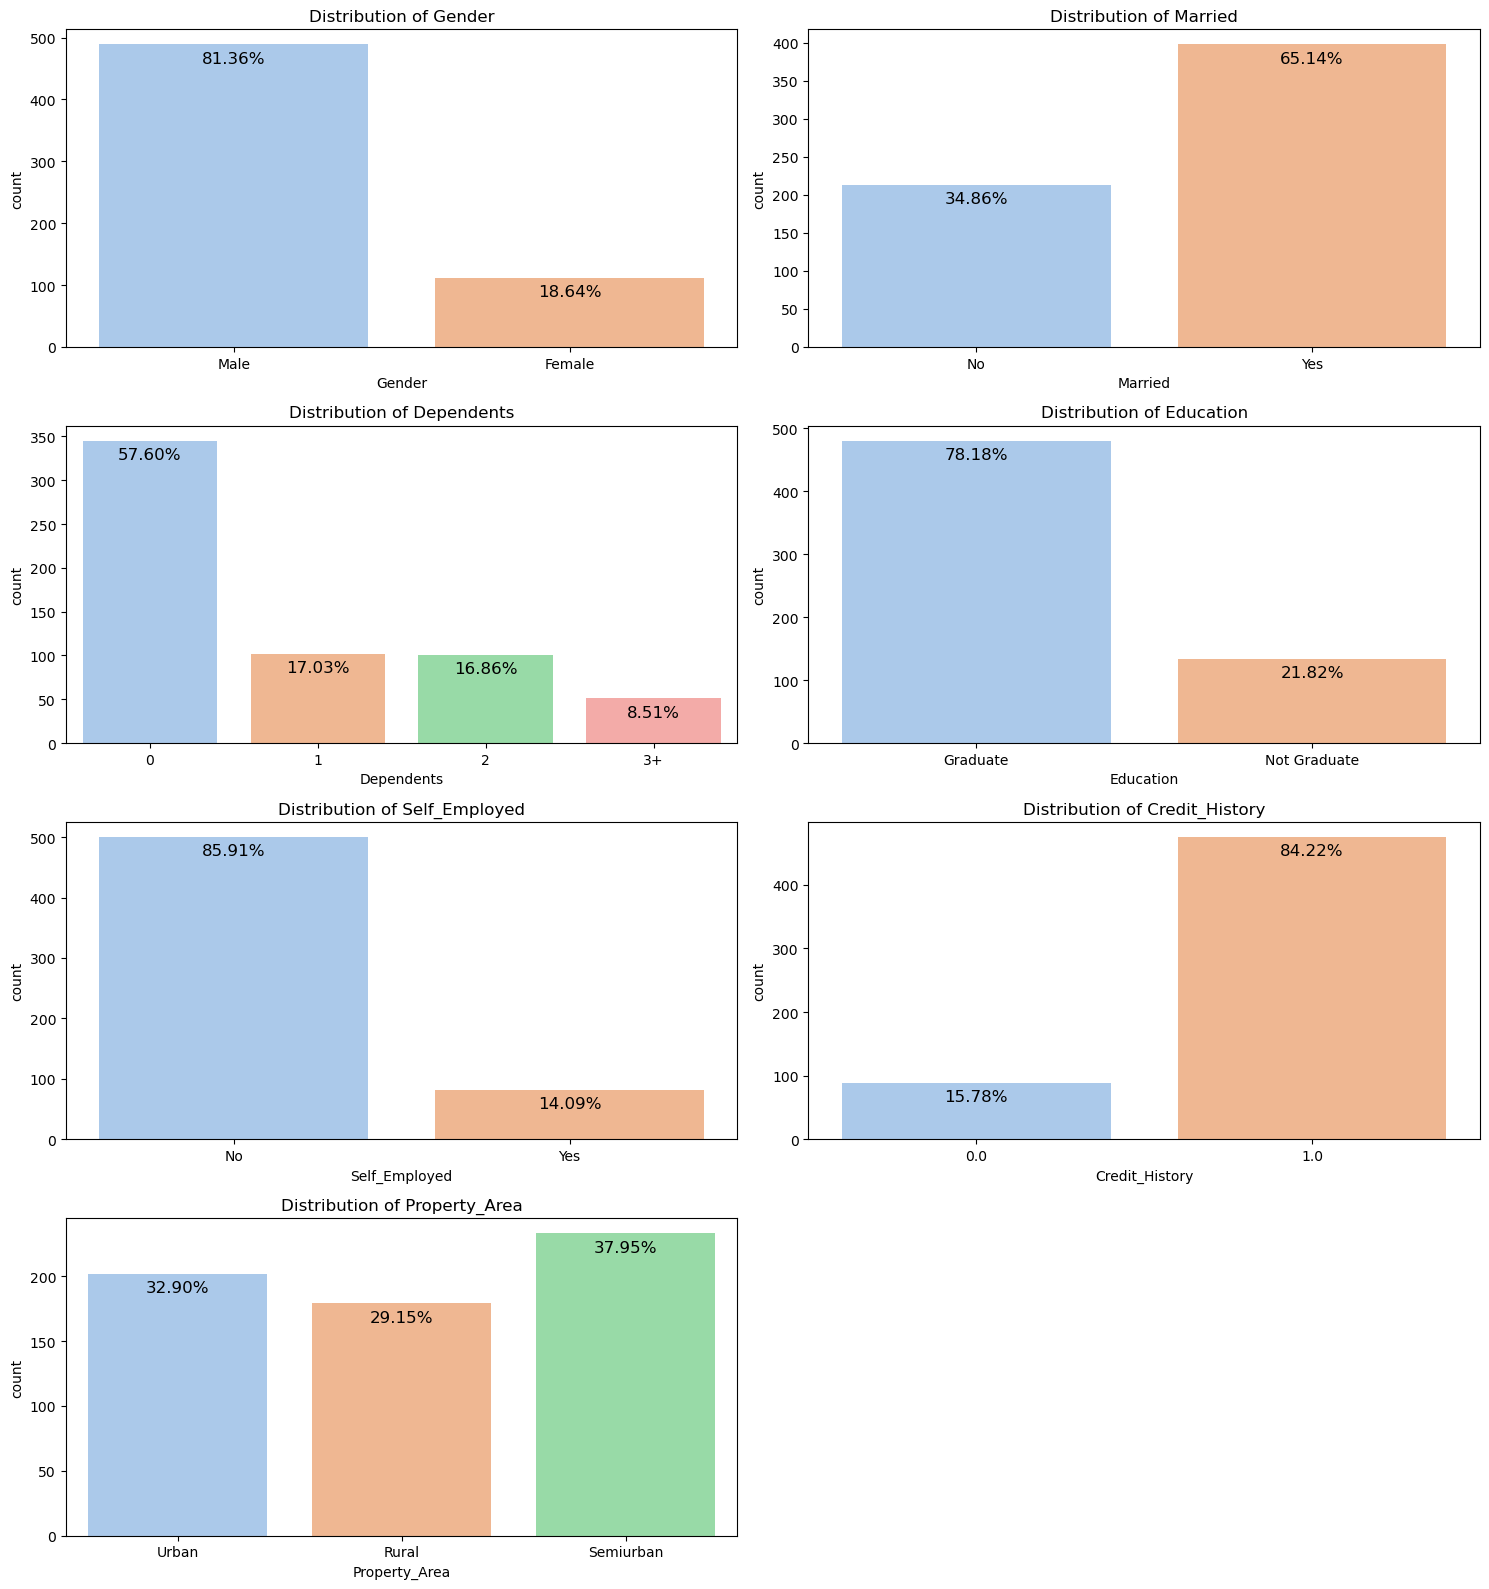

In [8]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                   'Credit_History', 'Property_Area']

n_cols = len(categorical_cols)
n_rows = (n_cols + 1) // 2  # Calculate needed rows

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4*n_rows))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=train, ax=axes[i], palette='pastel')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=0)
    
    # Add percentage labels
    total = len(train[col].dropna())
    for p in axes[i].patches:
        percentage = f'{100 * p.get_height() / total:.2f}%'
        axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, -10), textcoords='offset points')

# Hide empty subplots
for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Most applicants are Male, Married, and Graduates. Self-employment is less common.

### Numerical Distributions

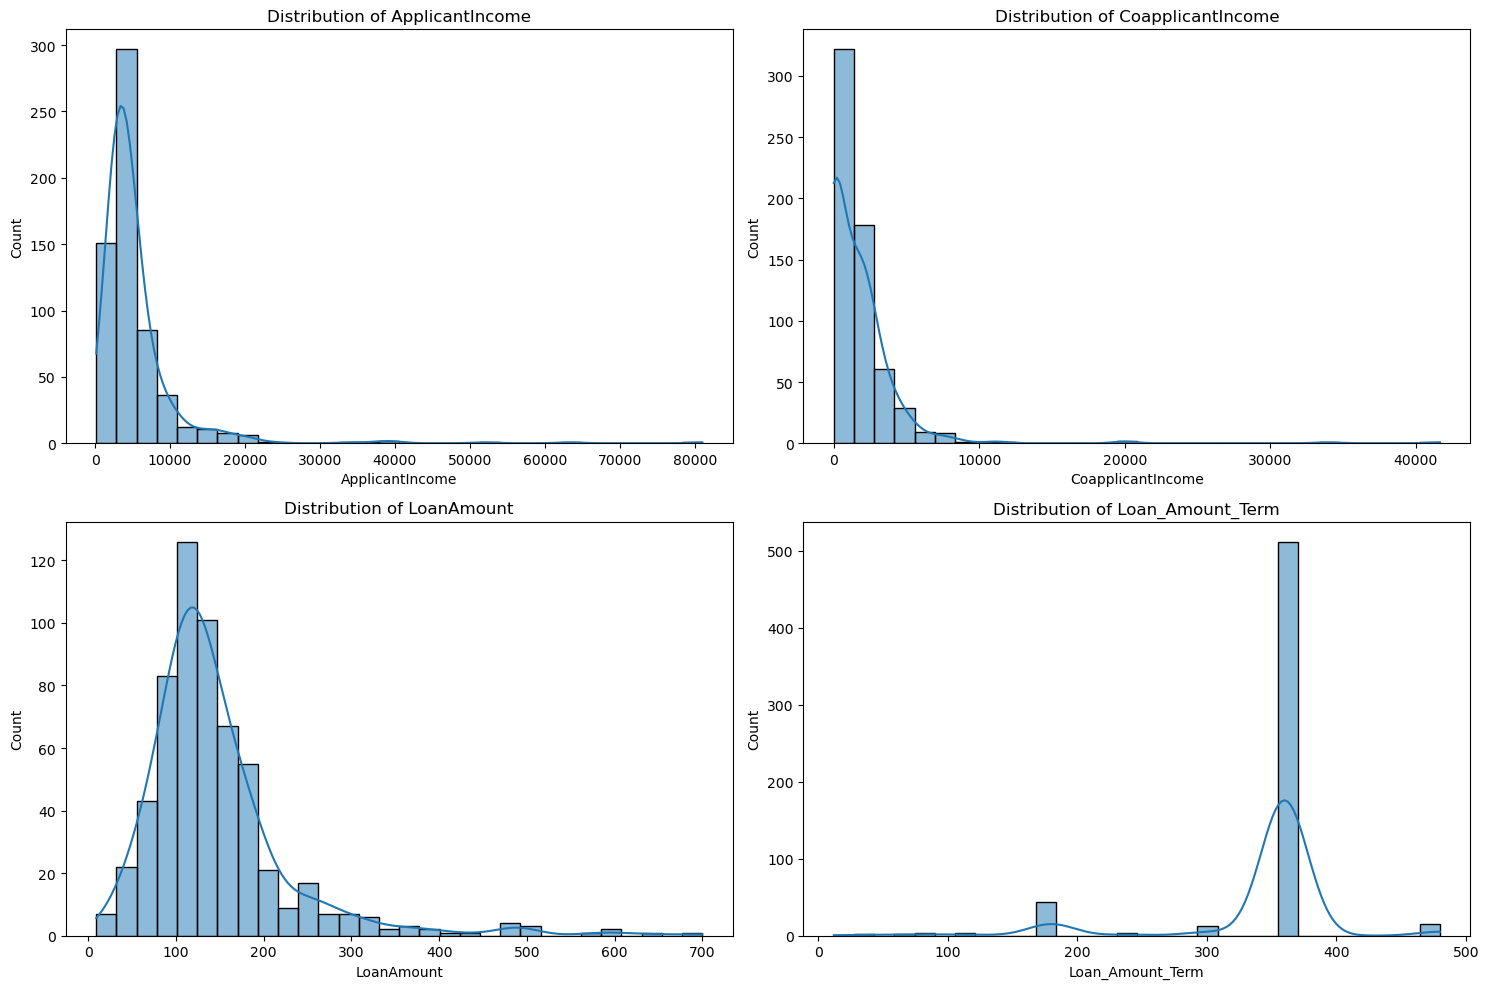

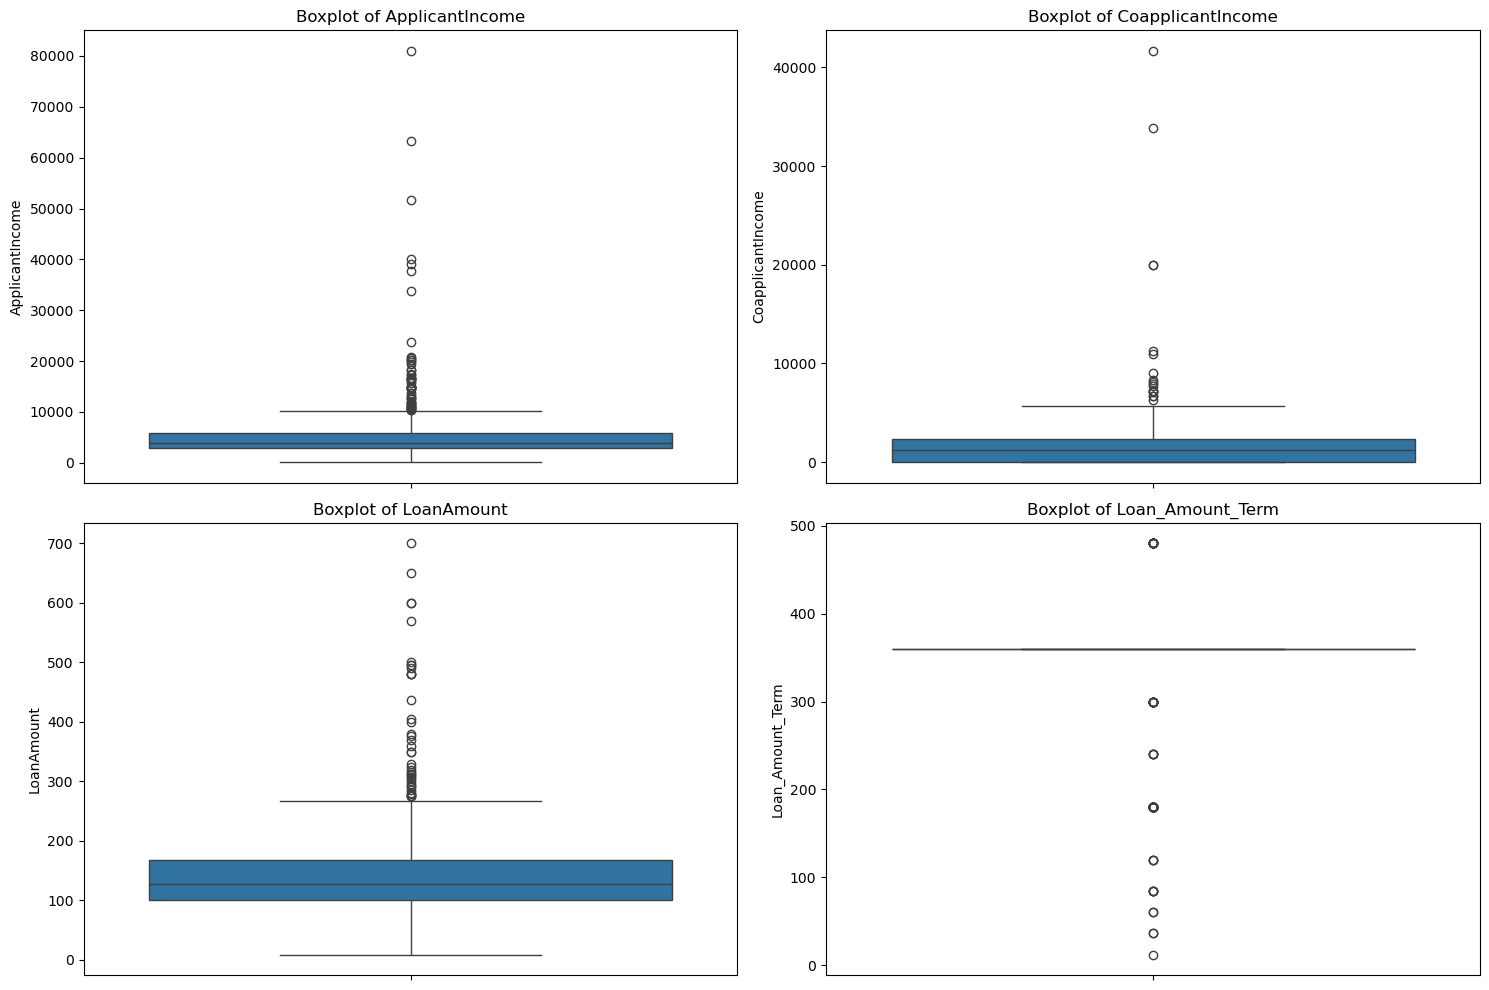

In [9]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Histogram with KDE
    sns.histplot(train[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

# Boxplots to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

Distributions for Income and LoanAmount are right-skewed, indicating a few applicants with very high income/loan requests. Log transformation might be beneficial.

### Correlations of each 


Correlations of numerical features with target variable 'Loan_Status':
ApplicantIncome: -0.0047
CoapplicantIncome: -0.0592
LoanAmount: -0.0373
Loan_Amount_Term: -0.0213


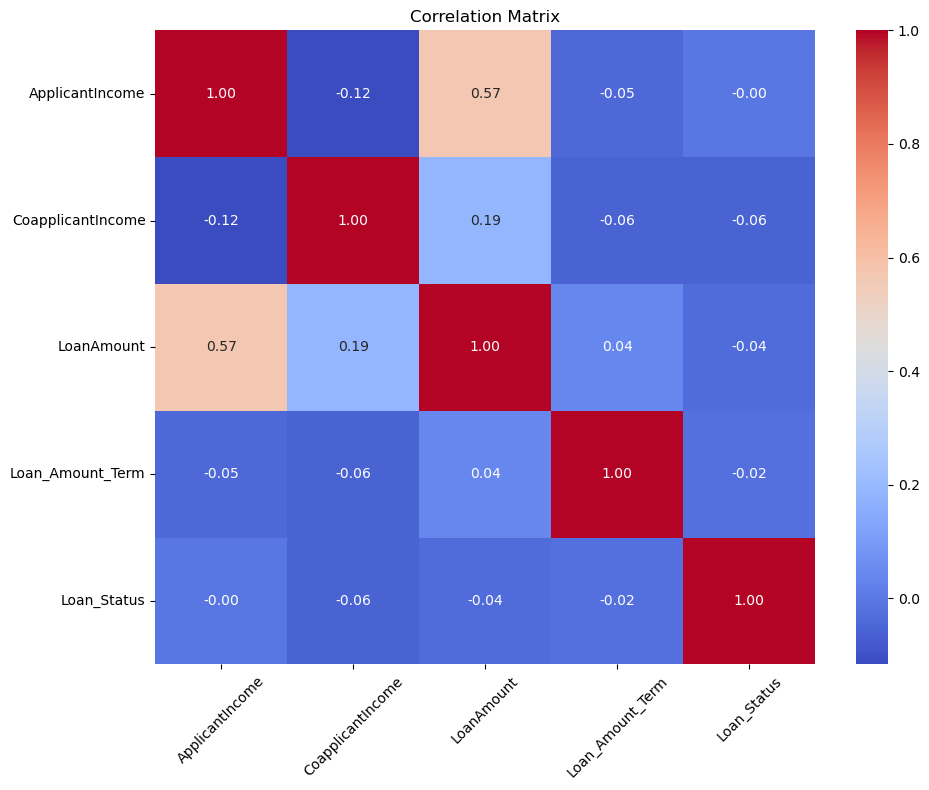

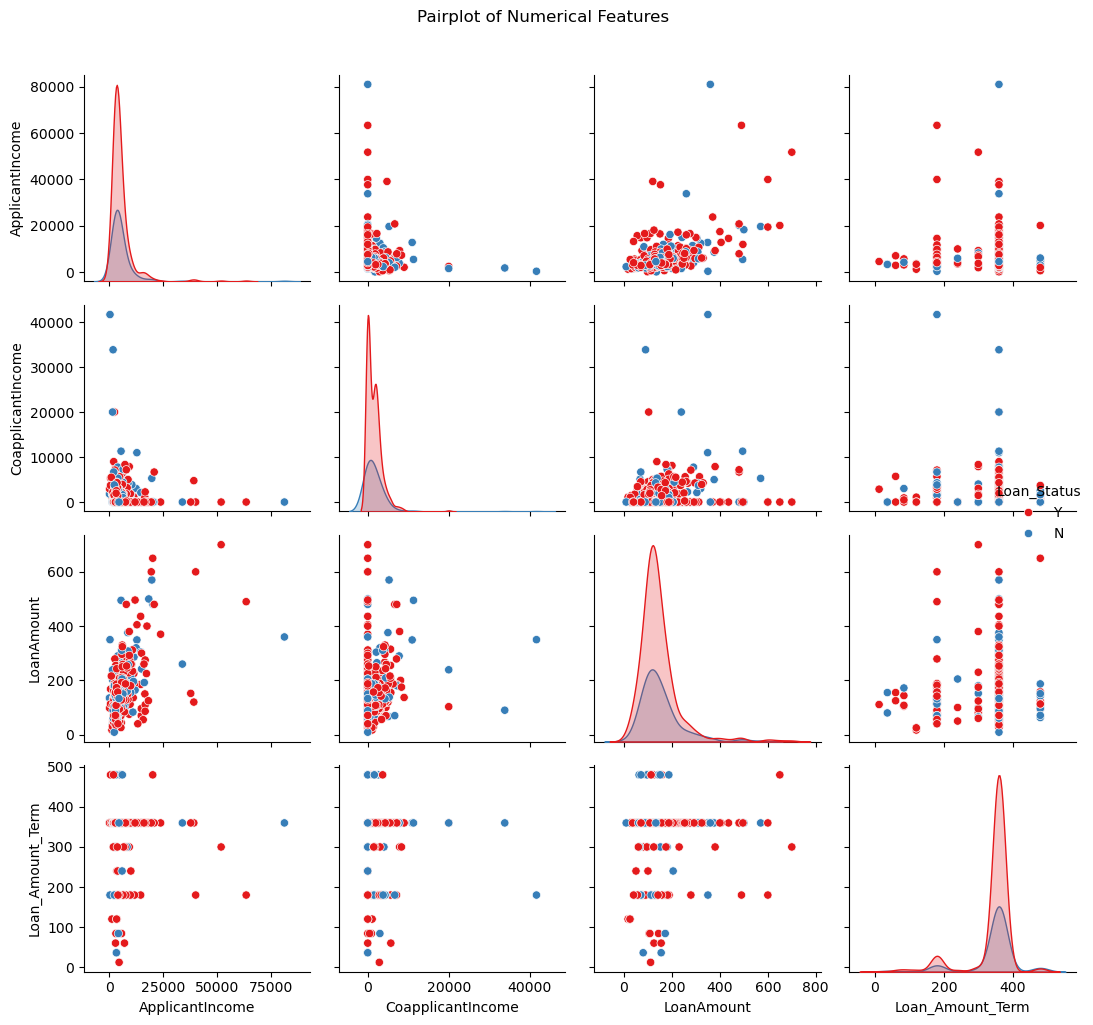

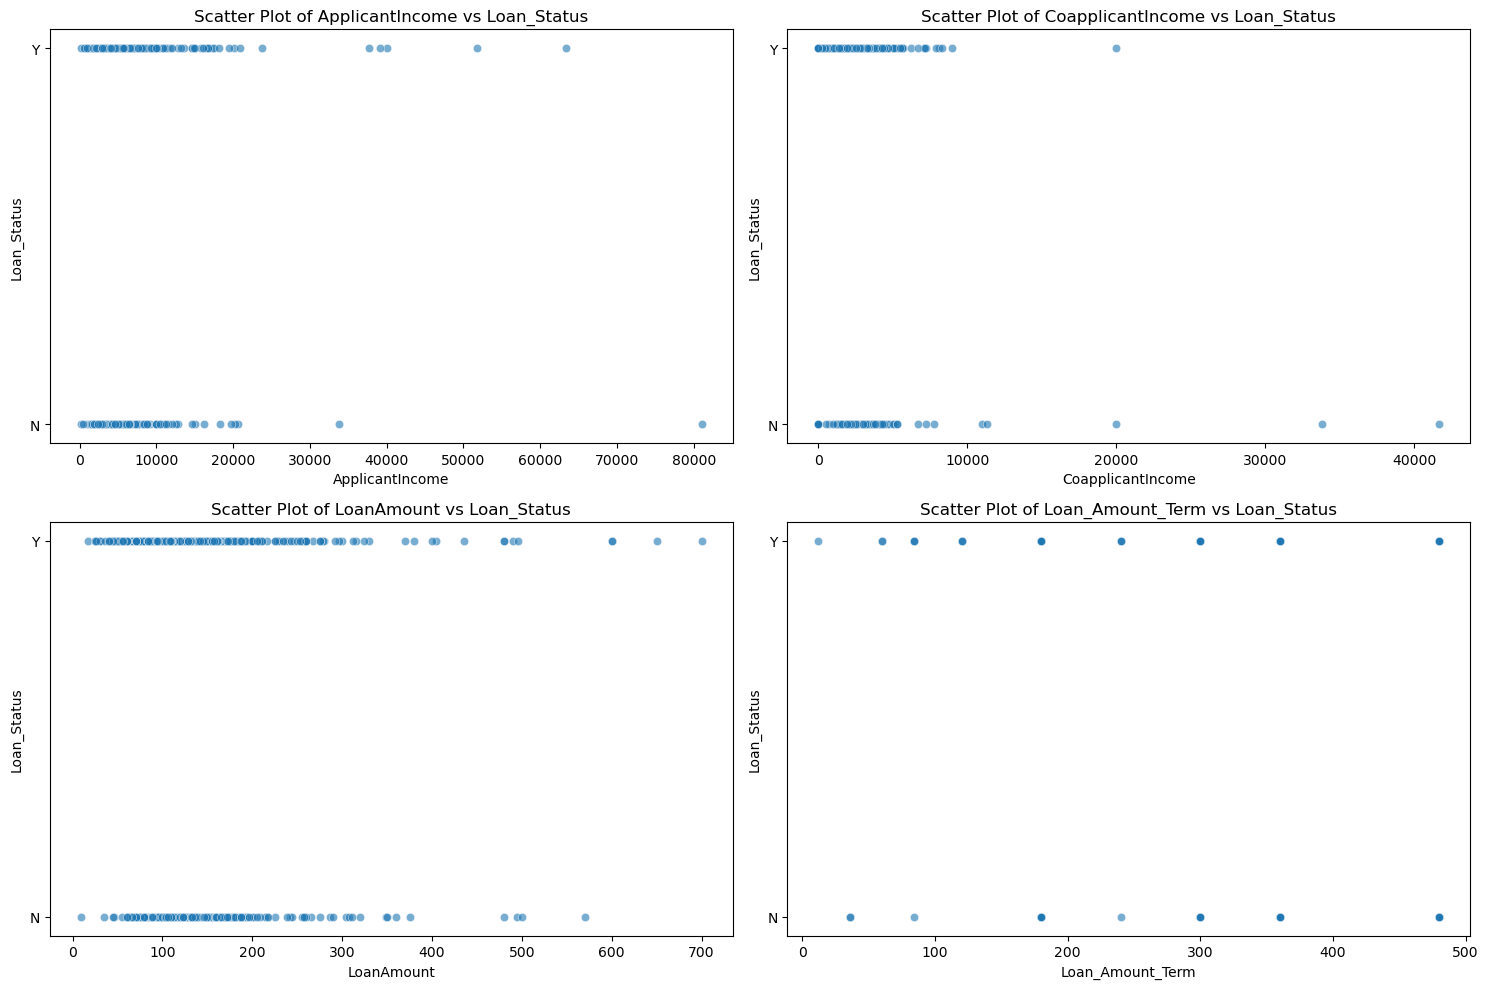

In [10]:
# Correlations of numerical features with target variable
correlations = {}
for col in numerical_cols:
    if train[col].dtype in [np.int64, np.float64]:
        correlation = train[col].corr(train['Loan_Status'].map({'Y': 1, 'N': 0}))
        correlations[col] = correlation
print("\nCorrelations of numerical features with target variable 'Loan_Status':")
for col, corr in correlations.items():
    print(f"{col}: {corr:.4f}")

# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = train[numerical_cols + ['Loan_Status']].copy()
corr_matrix['Loan_Status'] = corr_matrix['Loan_Status'].map({'Y': 1, 'N': 0})
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(train[numerical_cols + ['Loan_Status']], hue='Loan_Status', palette='Set1')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

# Scatter plots of numerical features against target variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=col, y='Loan_Status', data=train, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'Scatter Plot of {col} vs Loan_Status')
plt.tight_layout()
plt.show()

`LoanAmount` is correlated with `ApplicantIncome`. `Credit_History` shows the strongest correlation with `Loan_Status`.

# Feature Engineering

### Cardinality Check

In [11]:
def check_cardinality(train, threshold=10):
    """
    Function to check cardinality of categorical features in the dataset.
    Parameters:
    train (DataFrame): The training dataset.
    threshold (int): The threshold for high cardinality.
    
    Returns:
    None: Prints the cardinality information.
    """
    unique_cols = train.select_dtypes(include=['number', 'object'])
    cat = [col for col in unique_cols.columns if unique_cols[col].nunique() <= threshold]

    result = []
    for col in cat:
        unique_count = train[col].nunique()
        unique_vals = train[col].unique()
        result.append((col, unique_count, unique_vals))
    return pd.DataFrame(result, columns=['Feature', 'Unique Count', 'Unique Values'])

check_cardinality(train)

,Feature,Unique Count,Unique Values
0,Gender,2,"[Male, Female, nan]"
1,Married,2,"[No, Yes, nan]"
2,Dependents,4,"[0, 1, 2, 3+, nan]"
3,Education,2,"[Graduate, Not Graduate]"
4,Self_Employed,2,"[No, Yes, nan]"
5,Loan_Amount_Term,10,"[360.0, 120.0, 240.0, nan, 180.0, 60.0, 300.0, 480.0, 36.0, 84.0, 12.0]"
6,Credit_History,2,"[1.0, 0.0, nan]"
7,Property_Area,3,"[Urban, Rural, Semiurban]"
8,Loan_Status,2,"[Y, N]"


Cardinality check reveals the number of unique values per column. `Loan_ID` is unique for every row. Categorical variables have low cardinality as expected.

### Skewness Check

In [12]:
# Select only numerical columns
numerical_cols = train.select_dtypes(include=['number']).columns

# Skewness Check
skewness = []

for col in numerical_cols:
    skew_value = round(train[col].skew(), 3)
    distribution = 'normal' if -0.5 < skew_value < 0.5 else 'skewed'
    skewness.append((col, skew_value, distribution))

# Skewness DataFrame
skewness_df = pd.DataFrame(skewness, columns=['Feature', 'Skewness', 'Distribution'])
print(skewness_df)

             Feature  Skewness Distribution
0    ApplicantIncome     6.540       skewed
1  CoapplicantIncome     7.492       skewed
2         LoanAmount     2.678       skewed
3   Loan_Amount_Term    -2.362       skewed
4     Credit_History    -1.882       skewed


Skewness check identifies the distribution of numerical features. `ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, `Loan_Amount_Term`, and `Credit_History` are skewed, which may require transformation (e.g., log transformation) to improve model performance.

## Data Preprocessing
In this section, we will perform feature engineering, split the data, and create a preprocessing pipeline.

### Feature Engineering
Creating `Total_Income` and applying log transformations to handle skewness.

In [13]:
# Credit_History into categorical variable
train['Credit_History'] = train['Credit_History'].map({0.0: 'N', 1.0: 'Y'})
test['Credit_History'] = test['Credit_History'].map({0.0: 'N', 1.0: 'Y'})

# Create Total_Income
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
test['Total_Income'] = test['ApplicantIncome'] + test['CoapplicantIncome']

# Log Transformation
train['LoanAmount_Log'] = np.log1p(train['LoanAmount'])
test['LoanAmount_Log'] = np.log1p(test['LoanAmount'])

train['Total_Income_Log'] = np.log1p(train['Total_Income'])
test['Total_Income_Log'] = np.log1p(test['Total_Income'])

# Drop original columns to avoid multicollinearity and redundancy
cols_to_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income', 'Loan_ID']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

print("Columns after feature engineering:")
print(train.columns)

Columns after feature engineering:
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_Log', 'Total_Income_Log'],
      dtype='object')


### Data Splitting
Separating features (X) and target (y), then splitting into training and validation sets (80/20).

In [14]:
# Separate Target and Features
X = train.drop(['Loan_Status'], axis=1)
y = train['Loan_Status'].map({'Y': 1, 'N': 0}) # Label Encoding for Target

# Create Validation Set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")

Training Shape: (491, 10)
Validation Shape: (123, 10)


### Preprocessing Pipeline
Defining a pipeline with `StandardScaler` and `SimpleImputer` (Median) for numerical features, and `SimpleImputer` (Mode) and `OneHotEncoder` for categorical features.

In [15]:
# Define column groups
numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numeric Transformer: StandardScaler + Median Imputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Mode Imputer + OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display the preprocessor
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Loan_Amount_Term', 'LoanAmount_Log', 'Total_Income_Log'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area'],
      dtype='object'))])

In [16]:
# Fit and Transform Train Data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Convert back to DataFrame for easier viewing
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

X_train_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_val_df = pd.DataFrame(X_val_processed, columns=all_feature_names)

print("Processed Training Data Shape:", X_train_df.shape)
display(X_train_df.head())
print("\nMissing values in processed data:", X_train_df.isnull().sum().sum())

Processed Training Data Shape: (491, 20)


,Loan_Amount_Term,LoanAmount_Log,Total_Income_Log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_N,Credit_History_Y,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.287611,1.433611,0.592713,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.287611,0.006046,-0.027136,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.287611,0.961681,0.524518,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.287611,-0.040792,-0.231371,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.287611,-0.580065,-0.644138,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0



Missing values in processed data: 0


## Model Training and Evaluation
We will train two models: **Logistic Regression** (as a baseline) and **Random Forest Classifier** (for better performance on complex data). We will evaluate them using Accuracy, Confusion Matrix, and Classification Report.

### 1. Logistic Regression

Logistic Regression Accuracy: 0.7886178861788617

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



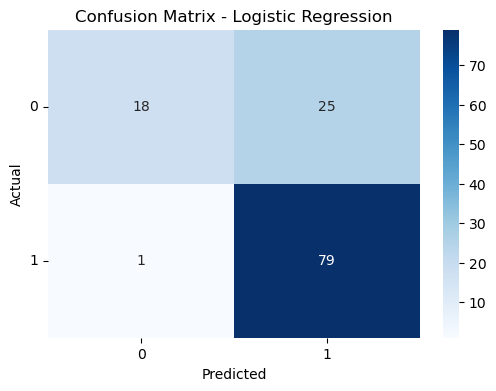

In [17]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_val_processed)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_val, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()

### 2. Random Forest Classifier

Random Forest Accuracy: 0.7560975609756098

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.42      0.55        43
           1       0.75      0.94      0.83        80

    accuracy                           0.76       123
   macro avg       0.77      0.68      0.69       123
weighted avg       0.76      0.76      0.73       123



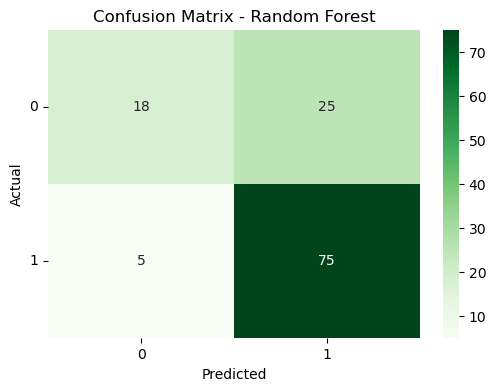

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_val_processed)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()

### Feature Importance (Random Forest)
Let's see which features contributed most to the decision.

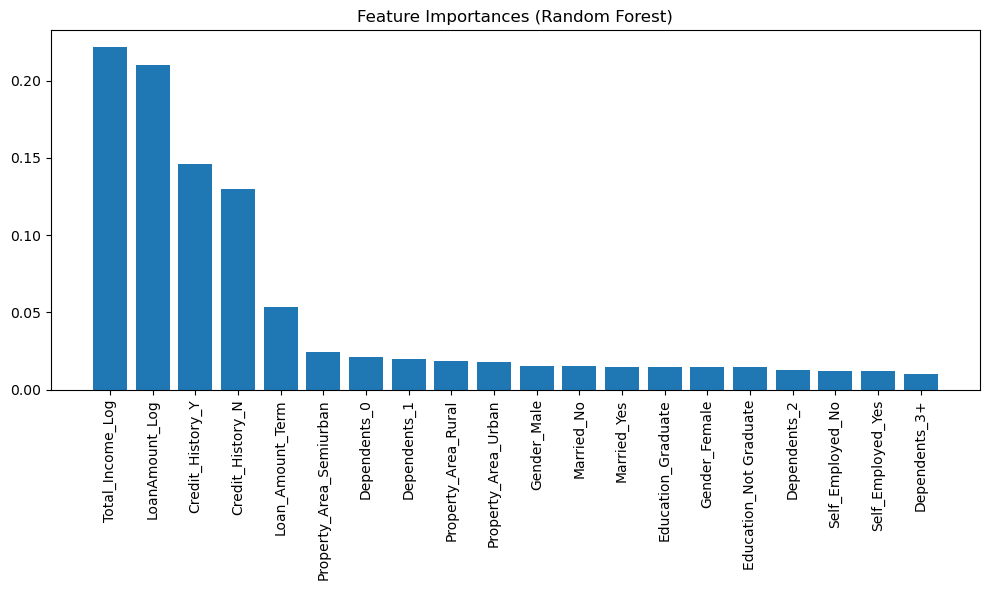

In [19]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train_processed.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_processed.shape[1]), [all_feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### 3. XGBoost Classifier
Implementing XGBoost, a powerful gradient boosting algorithm known for high performance.

XGBoost Accuracy: 0.7723577235772358

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.49      0.60        43
           1       0.77      0.93      0.84        80

    accuracy                           0.77       123
   macro avg       0.77      0.71      0.72       123
weighted avg       0.77      0.77      0.76       123



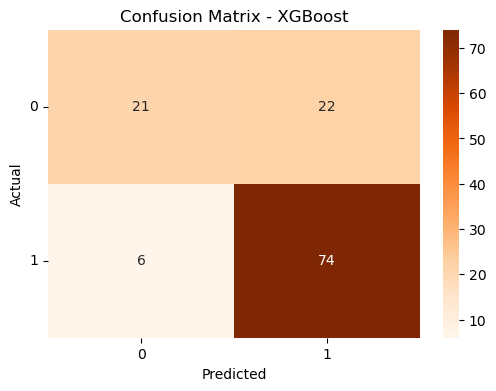

In [20]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_processed, y_train)
y_pred_xgb = xgb_model.predict(X_val_processed)

print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()

### Model Comparison
Comparing the accuracy of all three models.

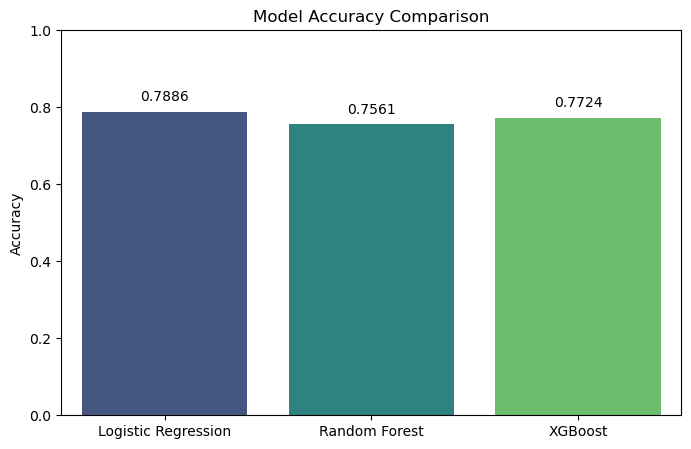

In [21]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [
    accuracy_score(y_val, y_pred_lr),
    accuracy_score(y_val, y_pred_rf),
    accuracy_score(y_val, y_pred_xgb)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.show()

### ROC-AUC Score Comparison
Evaluating models based on their ability to distinguish between classes.

In [22]:
# Calculate ROC-AUC (requires probability predictions)
roc_auc_lr = roc_auc_score(y_val, lr_model.predict_proba(X_val_processed)[:, 1])
roc_auc_rf = roc_auc_score(y_val, rf_model.predict_proba(X_val_processed)[:, 1])
roc_auc_xgb = roc_auc_score(y_val, xgb_model.predict_proba(X_val_processed)[:, 1])

print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.4f}")
print(f"XGBoost ROC-AUC: {roc_auc_xgb:.4f}")

Logistic Regression ROC-AUC: 0.7459
Random Forest ROC-AUC: 0.7167
XGBoost ROC-AUC: 0.7009


## Hyperparameter Tuning
Optimizing the XGBoost model using `GridSearchCV` to find the best combination of parameters.

In [23]:
# Define parameter grid
# Expanded grid to try and beat Logistic Regression
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0], # Fraction of columns to be randomly samples for each tree
    'min_child_weight': [1, 3] # higher values prevent overfitting
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=5, # 5-fold Cross Validation
    scoring='roc_auc', # Changed to optimize for ROC-AUC directly!
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_search.fit(X_train_processed, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC-AUC:", grid_search.best_score_)

Starting Grid Search...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation ROC-AUC: 0.8002019823421623


### Evaluate Tuned Model
Checking the performance of the best model on the validation set.

In [24]:
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_val_processed)

print("Tuned XGBoost Accuracy:", accuracy_score(y_val, y_pred_best))
print("\nClassification Report:\n", classification_report(y_val, y_pred_best))

# ROC-AUC for Tuned Model
roc_auc_best = roc_auc_score(y_val, best_xgb.predict_proba(X_val_processed)[:, 1])
print(f"Tuned XGBoost ROC-AUC: {roc_auc_best:.4f}")

Tuned XGBoost Accuracy: 0.7804878048780488

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.49      0.61        43
           1       0.77      0.94      0.85        80

    accuracy                           0.78       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.79      0.78      0.76       123

Tuned XGBoost ROC-AUC: 0.7183


## Test Set Prediction
Generating predictions for the unseen test dataset and saving them for submission.

In [25]:
# Reload Test Data to get Loan_ID (since we dropped it in 'test' dataframe)
test_original = pd.read_csv('data/loan-test.csv')
loan_ids = test_original['Loan_ID']

# Transform the test data using the fitted preprocessor
# Note: 'test' dataframe was already feature-engineered in the Preprocessing section
X_test_processed = preprocessor.transform(test)

# Predict using the Logistic Regression model (Our Winner!)
test_predictions = lr_model.predict(X_test_processed)

# Create Submission DataFrame
submission = pd.DataFrame({
    'Loan_ID': loan_ids,
    'Loan_Status': test_predictions
})

# Map 1/0 back to Y/N
submission['Loan_Status'] = submission['Loan_Status'].map({1: 'Y', 0: 'N'})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission saved to 'submission.csv'")
display(submission.head())

Submission saved to 'submission.csv'


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
